<a href="https://colab.research.google.com/github/duybluemind1988/Data-science/blob/master/IGI_material_control_prediction%20v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#!pip install altair_viewer #Need to install this package

In [4]:
#!pip install jupyter altair vega #No need to install this package

In [12]:
# VERY IMPORTANT INFORMATION
print('Please input number of feature')
feature_num=5
print('Please input number of sample inspection')
sample_num=5
print('Please input position of sample value')
namefile='MMD2019'


Please input number of feature
Please input number of sample inspection
Please input position of sample value


In [13]:
import datetime
import seaborn as sns; sns.set()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from plotly.offline import iplot
import pandas as pd
import re
import altair as alt

from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
import scipy.stats as scs
from math import sqrt
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler

In [14]:
#alt.renderers.enable('notebook')
#alt.renderers.enable('mimetype')

In [15]:
import os
os.getcwd()

'/content'

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [19]:
path='/content/drive/My Drive/Data/Sonion/IGI material Membrane 2019/'
#path='/content/drive/My Drive/Data science/Sonion project/IGI material Armature/'
#path1='/content/drive/My Drive/Data/MMD 2019/'
#path2='/content/drive/My Drive/Data/MMD 2018/'

### read all excel file and sort  by day

In [20]:
import glob
#print(path)
all_files1=glob.glob(path + '*.xlsx')
all_files2=glob.glob(path + '*.xlsm')
all_files=all_files1+all_files2
#sort file in directory by reverse:
all_files = sorted(all_files, reverse = False)
print('number of files: ',len(all_files))

number of files:  29


### Initial number of feature and sample:

### add all dataframe to list of dataframe:

In [21]:
finaldf=pd.DataFrame()
for filename in all_files:
    df = pd.read_excel(filename, index_col = None, header = 0)
    #Create data frame feature values(newdf)
    newdf=pd.DataFrame()
    for i in range(feature_num+1)[1:]:
      df_feature= df['Unnamed: '+str(i)][19:(19+sample_num)] #must be = 19 + sample_num /24 la mac dinh
      df_feature=df_feature.reset_index(drop=True)
      newdf=pd.concat([newdf,df_feature],axis=1)
    #print(newdf)  

    #Date transform:
    a=df[['Unnamed: 7']][3:4] #object type - normal is [2:3]
    if a.isna().values:
      a=df[['Unnamed: 7']][2:3]
      date = a.values[0][0] #timestamp type
    else:
      date = a.values[0][0] #timestamp type
    if isinstance(date, str):
      continue
    #Create series date column (row = number of value to record, default = 5)
    date=pd.Series(date)
    datedf=pd.DataFrame()
    for i in range(sample_num):
      datedf=pd.concat([datedf,date],axis=0)

    datedf.reset_index(drop=True, inplace=True)
    newdf.reset_index(drop=True, inplace=True)
    df_combine=pd.concat([datedf,newdf],axis=1) # combine date and features

    #combine all df each filename:
    
    finaldf=pd.concat([finaldf,df_combine],axis=0)
print(finaldf.isnull().sum())
finaldf.reset_index(drop=True,inplace=True)
finaldf.sort_values(by=finaldf.columns[0])
finaldf

0             0
Unnamed: 1    0
Unnamed: 2    0
Unnamed: 3    0
Unnamed: 4    0
Unnamed: 5    0
dtype: int64


,0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5
0,2019-01-11,10.003,1.219,3.197,11.855,0.31
1,2019-01-11,10.005,1.219,3.19,11.855,0.31
2,2019-01-11,10.005,1.219,3.194,11.852,0.31
3,2019-01-11,10.002,1.218,3.198,11.855,0.311
4,2019-01-11,10.003,1.219,3.19,11.85,0.31
...,...,...,...,...,...,...
140,2019-12-31,9.991,1.218,3.199,11.85,0.313
141,2019-12-31,9.999,1.218,3.204,11.849,0.314
142,2019-12-31,10.003,1.219,3.202,11.847,0.313
143,2019-12-31,10.002,1.219,3.201,11.847,0.312


In [22]:
#finaldf.to_csv('finaldfMMD.csv')

In [23]:
finaldf.dropna(inplace=True)
finaldf  

,0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5
0,2019-01-11,10.003,1.219,3.197,11.855,0.31
1,2019-01-11,10.005,1.219,3.19,11.855,0.31
2,2019-01-11,10.005,1.219,3.194,11.852,0.31
3,2019-01-11,10.002,1.218,3.198,11.855,0.311
4,2019-01-11,10.003,1.219,3.19,11.85,0.31
...,...,...,...,...,...,...
140,2019-12-31,9.991,1.218,3.199,11.85,0.313
141,2019-12-31,9.999,1.218,3.204,11.849,0.314
142,2019-12-31,10.003,1.219,3.202,11.847,0.313
143,2019-12-31,10.002,1.219,3.201,11.847,0.312


In [24]:
finaldf.reset_index(drop=True,inplace=True)
column_name=[]
column_name.append('Datef')
for i in range(feature_num+1)[1:]:
  #print(df['Unnamed: '+str(i)][7])
  namecolumn_temp=df['Unnamed: '+str(i)][7]
  namecolumn_temp=namecolumn_temp.replace('.','')
  column_name.append(namecolumn_temp)
finaldf.columns=column_name
finaldf.sort_values(by='Datef') #sort dated , not depend on file sorting
for name in finaldf.columns[1:]:
  try:
    finaldf[name]=finaldf[name].astype(float)
  except:
    continue
finaldf[:3] 

,Datef,C-Pitch,J,I,O,Z
0,2019-01-11,10.003,1.219,3.197,11.855,0.31
1,2019-01-11,10.005,1.219,3.190,11.855,0.31
2,2019-01-11,10.005,1.219,3.194,11.852,0.31


In [25]:
finaldf.dtypes

Datef      datetime64[ns]
C-Pitch           float64
J                 float64
I                 float64
O                 float64
Z                 float64
dtype: object

In [26]:
finaldf = finaldf.select_dtypes(exclude=['object'])
finaldf.dtypes

Datef      datetime64[ns]
C-Pitch           float64
J                 float64
I                 float64
O                 float64
Z                 float64
dtype: object

Auto remove columns if non nummeris >10%, if non numberic < 10% remove row :

In [27]:
newdf_test=finaldf.copy()
max_row=len(newdf_test)
print(max_row)
for name in newdf_test.columns[1:]:
    a=newdf_test[name]
    non_numeric_column=pd.DataFrame(a)[~pd.DataFrame(a).applymap(np.isreal).all(1)]
    num_row_nonnumeric=len(non_numeric_column)
    print('number of non numeric row in column '+ name + ' before:'+ str(num_row_nonnumeric))
    if num_row_nonnumeric < max_row*0.1:
        list_to_exclude=non_numeric_column.index.values.tolist()
        newdf_test=newdf_test[~newdf_test.index.isin(list_to_exclude)]
        newdf_test[name]=newdf_test[name].astype(float)
    else:
        newdf_test.drop(columns=name,inplace=True)
print('Check result after process')       
for name in newdf_test.columns[1:]:
    a=newdf_test[name]
    non_numeric_column=pd.DataFrame(a)[~pd.DataFrame(a).applymap(np.isreal).all(1)]
    num_row_nonnumeric=len(non_numeric_column)
    print('number of non numeric row in column '+ name + ' after:'+ str(num_row_nonnumeric))
finaldf = newdf_test

145
number of non numeric row in column C-Pitch before:0
number of non numeric row in column J before:0
number of non numeric row in column I before:0
number of non numeric row in column O before:0
number of non numeric row in column Z before:0
Check result after process
number of non numeric row in column C-Pitch after:0
number of non numeric row in column J after:0
number of non numeric row in column I after:0
number of non numeric row in column O after:0
number of non numeric row in column Z after:0


### set up tolerance dict:USL,LSL,Nominal

In [28]:
#set up tolerance dict:USL,LSL,Nominal
#Tolerance set up when not drop object type column, not reflect exactly tolerance vs data analysis
tolerance={}
for column in df.columns[1:(feature_num+1)]:
    namecolumn_temp=df[column][7] #df: dataframe latest in for loop
    namecolumn_temp=namecolumn_temp.replace('.','')
    tolerance[namecolumn_temp] =[df[column][9],df[column][10],df[column][15]]
tolerance

{'C-Pitch': [10.01, 9.99, 10],
 'I': [3.21, 3.1900000000000004, 3.2],
 'J': [1.22, 1.21, 1.21],
 'O': [11.86, 11.84, 11.85],
 'Z': [0.32, 0.27999999999999997, 0.3]}

In [29]:
#Create list of dataframe, combine feature value and USL,LSL, Nominal
DFdict={}
for name in finaldf.columns[1:]:
    print('Chart: ',name)
        
    #Create series USL:
    USL = tolerance[name][0]
    USL=pd.Series(USL)
    s1=pd.DataFrame()
    for i in range(len(finaldf)):
      s1=pd.concat([s1,USL],axis=0)
    s1.rename(columns={0:'USL'},inplace=True)
    
    #Create series LSL:
    LSL = tolerance[name][1]
    LSL=pd.Series(LSL)
    s2=pd.DataFrame()
    for i in range(len(finaldf)):
      s2=pd.concat([s2,LSL],axis=0)
    s2.rename(columns={0:'LSL'},inplace=True)
    
    #Create series nominal:
    nominal = tolerance[name][2]
    nominal=pd.Series(nominal)
    s3=pd.DataFrame()
    for i in range(len(finaldf)):
      s3=pd.concat([s3,nominal],axis=0)
    s3.rename(columns={0:'Nominal'},inplace=True)
    
    #combine Date,feature, LSL,USL,nominal to finaldataframe (for each feature):
    finaldf['Datef'].reset_index(drop=True,inplace=True)
    finaldf[name].reset_index(drop=True,inplace=True)
    s1.reset_index(drop=True,inplace=True)
    s2.reset_index(drop=True,inplace=True)
    s3.reset_index(drop=True,inplace=True)
    df_temp = pd.concat([finaldf['Datef'],finaldf[name],s1,s2,s3],axis=1)  

    #Create dict of dataframe for each feature columns:
    DFdict[name]=df_temp # Include Date, name, USL, LSL, nominal each parameter(J, I, O or Z...)
    #print(DFdict[name][:3])
    

Chart:  C-Pitch
Chart:  J
Chart:  I
Chart:  O
Chart:  Z


In [30]:
print(DFdict.keys())
#df=DFdict['J']
#print(df.columns)
for name in DFdict.keys():
  print(name)
  print(DFdict[name][:3])

dict_keys(['C-Pitch', 'J', 'I', 'O', 'Z'])
C-Pitch
       Datef  C-Pitch    USL   LSL  Nominal
0 2019-01-11   10.003  10.01  9.99     10.0
1 2019-01-11   10.005  10.01  9.99     10.0
2 2019-01-11   10.005  10.01  9.99     10.0
J
       Datef      J   USL   LSL  Nominal
0 2019-01-11  1.219  1.22  1.21     1.21
1 2019-01-11  1.219  1.22  1.21     1.21
2 2019-01-11  1.219  1.22  1.21     1.21
I
       Datef      I   USL   LSL  Nominal
0 2019-01-11  3.197  3.21  3.19      3.2
1 2019-01-11  3.190  3.21  3.19      3.2
2 2019-01-11  3.194  3.21  3.19      3.2
O
       Datef       O    USL    LSL  Nominal
0 2019-01-11  11.855  11.86  11.84    11.85
1 2019-01-11  11.855  11.86  11.84    11.85
2 2019-01-11  11.852  11.86  11.84    11.85
Z
       Datef     Z   USL   LSL  Nominal
0 2019-01-11  0.31  0.32  0.28      0.3
1 2019-01-11  0.31  0.32  0.28      0.3
2 2019-01-11  0.31  0.32  0.28      0.3


In [31]:
DFdict_final={}
for name in DFdict.keys():
  df=DFdict[name].copy()
  df_group=df.groupby('Datef').mean() # mean value by Date
  df_group.reset_index(inplace=True)

  value_name=df_group.columns[1] #'C-Pitch', 'J', 'I', 'O', 'Z'
  df_group[value_name] = df_group[value_name].round(decimals=3)
  #---------------------------------------------------------------#

  # Create a selection that chooses the nearest point & selects based on x-value
  #UCL,LCL,nominal:
  sigma=3
  df_final = df_group.assign(
                UCL=df_group[value_name].mean() + df_group[value_name].std()*sigma,
                LCL=df_group[value_name].mean() - df_group[value_name].std()*sigma,
                mean=df_group[value_name].mean())
  DFdict_final[name]=df_final

In [32]:
print(DFdict_final.keys())
#df=DFdict['J']
#print(df.columns)
for name in DFdict_final.keys():
  print(name)
  print(DFdict_final[name][:3])

dict_keys(['C-Pitch', 'J', 'I', 'O', 'Z'])
C-Pitch
       Datef  C-Pitch    USL   LSL  Nominal        UCL       LCL       mean
0 2019-01-11   10.004  10.01  9.99     10.0  10.006001  9.997142  10.001571
1 2019-01-22   10.001  10.01  9.99     10.0  10.006001  9.997142  10.001571
2 2019-01-26   10.002  10.01  9.99     10.0  10.006001  9.997142  10.001571
J
       Datef      J   USL   LSL  Nominal       UCL       LCL      mean
0 2019-01-11  1.219  1.22  1.21     1.21  1.222084  1.216344  1.219214
1 2019-01-22  1.219  1.22  1.21     1.21  1.222084  1.216344  1.219214
2 2019-01-26  1.220  1.22  1.21     1.21  1.222084  1.216344  1.219214
I
       Datef      I   USL   LSL  Nominal       UCL       LCL      mean
0 2019-01-11  3.194  3.21  3.19      3.2  3.206102  3.191327  3.198714
1 2019-01-22  3.199  3.21  3.19      3.2  3.206102  3.191327  3.198714
2 2019-01-26  3.200  3.21  3.19      3.2  3.206102  3.191327  3.198714
O
       Datef       O    USL    LSL  Nominal        UCL        LCL      

In [48]:
len(DFdict_final)

5

### Line chart plotly

In [68]:
i=1
#Layout
fig = make_subplots(
    rows=len(DFdict_final), cols=1,
    shared_xaxes=True,
    vertical_spacing=0.05,
    #column_widths=[0.8, 0.2],
    subplot_titles=(list(DFdict_final.keys()))
)
for name in DFdict_final.keys(): #also group
  df=DFdict_final[name].copy()
  df=df.sort_values(by=['Datef'])
  for a in df.columns[1:]:
    df[a] = df[a].round(decimals=3)

  #Control chart 1 
  fig.append_trace(go.Scatter(
                          x=df['Datef'], y=df[name],
                          mode='lines+markers',
                          name='mean ' + name,line=dict( color='#4280F5')
                          ),row=i, col=1
                )
  #USL, LSL
  fig.append_trace(go.Scatter(x=df['Datef'], y=df['USL'],name='USL '+name, line=dict( color='#FF5733')),row=i, col=1)
  fig.append_trace(go.Scatter(x=df['Datef'], y=df['LSL'],name='LSL '+name,line=dict( color='#FF5733')),row=i, col=1)
  fig.append_trace(go.Scatter(x=df['Datef'], y=df['Nominal'],name='Nominal '+name,line=dict( color='#FF5733')),row=i, col=1)
  # UCL, LCL
  fig.append_trace(go.Scatter(x=df['Datef'], y=df['UCL'],name='UCL '+name, line=dict( color='#33C2FF')),row=i, col=1)
  fig.append_trace(go.Scatter(x=df['Datef'], y=df['LCL'],name='LCL '+name, line=dict( color='#33C2FF')),row=i, col=1)
  fig.append_trace(go.Scatter(x=df['Datef'], y=df['mean'],name='mean '+name, line=dict( color='#33C2FF')),row=i, col=1)

  #Final layout:
  #fig.update_layout(height=400, width=1400, title_text='Line chart'+name)
  i=i+1
  
fig.update_layout(height=200*len(DFdict_final), width=1200, title_text='Line chart')
# Add range slider
fig.update_layout(
    xaxis5=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,label="1m",step="month",stepmode="backward"),
                dict(count=6,label="6m",step="month",stepmode="backward"),
                dict(count=1,label="YTD",step="year",stepmode="todate"),
                dict(count=1,label="1y",step="year",stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(visible=True),type="date",
        rangeslider_thickness=0.05
    )
)
#fig.update_layout(legend_orientation="h", 
#             xaxis3_rangeslider_visible=True, xaxis3_rangeslider_thickness=0.1 )
fig.show()

### Box chart altair

In [25]:
import json
import datetime 

#Function convert datetime to json
def defaulta(obj):
      if isinstance(obj, (datetime.date, datetime.datetime)):
          return obj.isoformat()

In [26]:

#Set up width and hist for all chart
width_main=800
height_main=150
width_hist=100

list_chart1=[]
for name in DFdict.keys():
  df_box=DFdict[name].copy() #All values for each features
  df_box['Datef']=df_box['Datef'].dt.date
  value_name2=df_box.columns[1] #'C-Pitch', 'J', 'I', 'O', 'Z'
  #Convert datetime to json
  df_box['Datef']=df_box['Datef'].apply(lambda x: json.dumps(x, default = defaulta) )
  base1 = alt.Chart(df_box).properties(width=width_main,height=height_main)

  #Create box plot, USL, LSL, Nominal
  box=base1.mark_boxplot().encode(
      x=alt.X(
          'Datef:O',scale=alt.Scale(),title="",
          ),
      y=alt.Y(value_name2+':Q',scale=alt.Scale(zero=False),title="")
  ).properties(width=width_main,height=height_main)

  line_USL=base1.mark_line(color='red').encode(
      x=alt.X('Datef:O',scale=alt.Scale(zero=False)),
      y=alt.Y('USL:Q',scale=alt.Scale(zero=False)),
  )

  line_LSL=base1.mark_line(color='red').encode(
      x=alt.X('Datef:O',scale=alt.Scale(zero=False)),
      y=alt.Y('LSL:Q',scale=alt.Scale(zero=False)),
  )

  line_Nominal=base1.mark_line(color='red').encode(
      x=alt.X('Datef:O',scale=alt.Scale(zero=False)),
      y=alt.Y('Nominal:Q',scale=alt.Scale(zero=False)),
  )

  chart=box + line_USL + line_LSL + line_Nominal

  #Sub chart create (Histogram, USL, LSL, Nominal)
  record_bar= alt.Chart(df_box).mark_bar().encode(
      x='count()',
      y=alt.Y(value_name2, bin=True,title="")
  ).properties(
      height=height_main,
      width=width_hist
  )

  USL_rule = alt.Chart(df_box).mark_rule(color='red').encode(
      y=alt.Y('USL'),
      size=alt.value(1)
  )
  LSL_rule = alt.Chart(df_box).mark_rule(color='red').encode(
      y=alt.Y('LSL'),
      size=alt.value(1)
  )
  Nominal_rule = alt.Chart(df_box).mark_rule(color='red').encode(
      y=alt.Y('Nominal'),
      size=alt.value(1)
  )

  sub_chart=record_bar + USL_rule + LSL_rule + Nominal_rule
  boxchart= 'chart' + name
  boxchart=alt.hconcat(chart,sub_chart).properties(title='Box Plot ' + value_name2)
  list_chart1.append(boxchart)
  boxchart
  #altair_viewer.display(boxchart, inline=True)
#boxchart_combine.save('boxchart_combine.html')


In [27]:
path=os.getcwd()
path

'/content'

In [28]:
namefile

'MMD2019'

In [29]:
box_chart_combine=alt.vconcat(data=df_group)
for chart in list_chart1:
  box_chart_combine &= chart
#box_chart_combine.save('box_chart_combine'+namefile+'.html')
box_chart_combine

alt.VConcatChart(...)

In [30]:
#box_chart_combine.save(namefile+'.html')

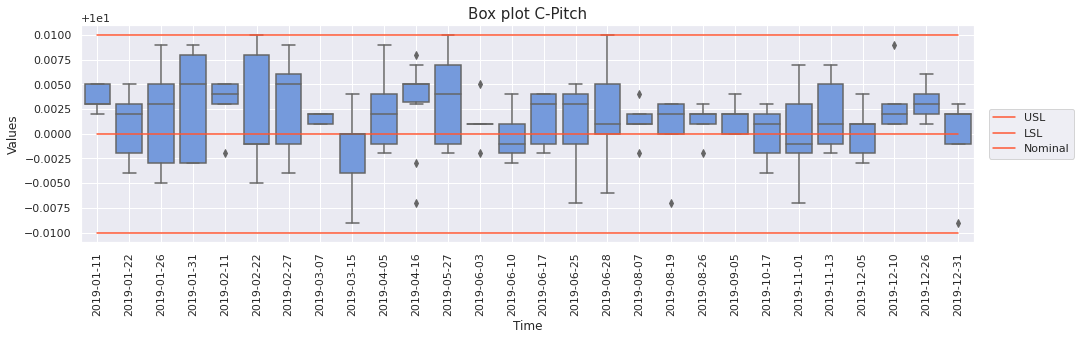

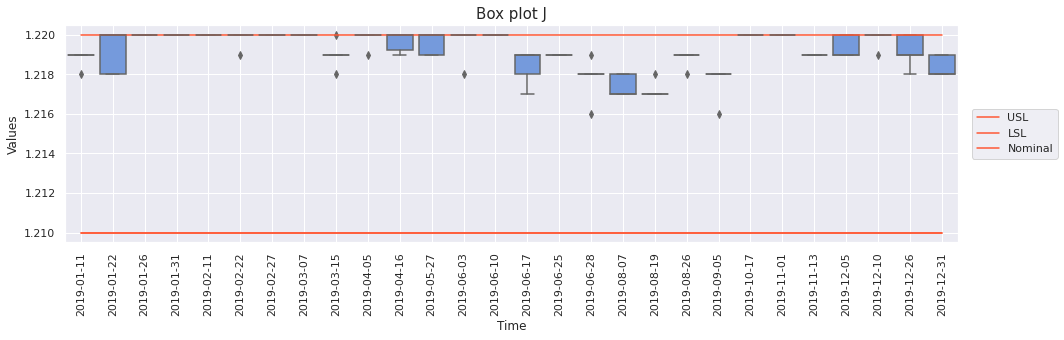

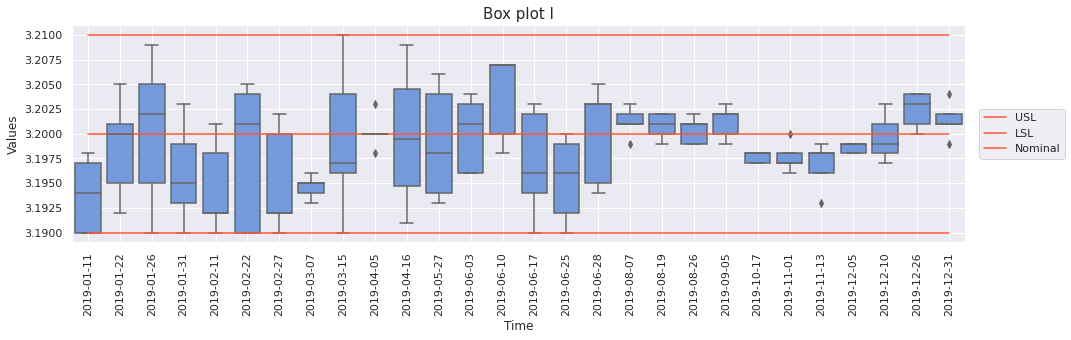

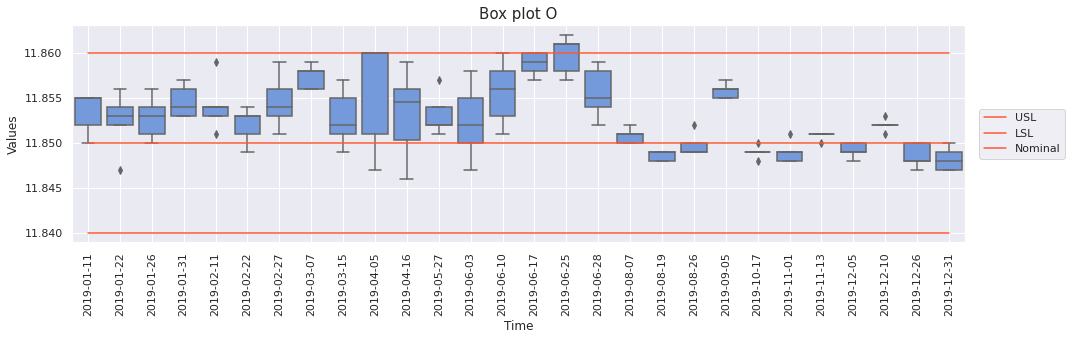

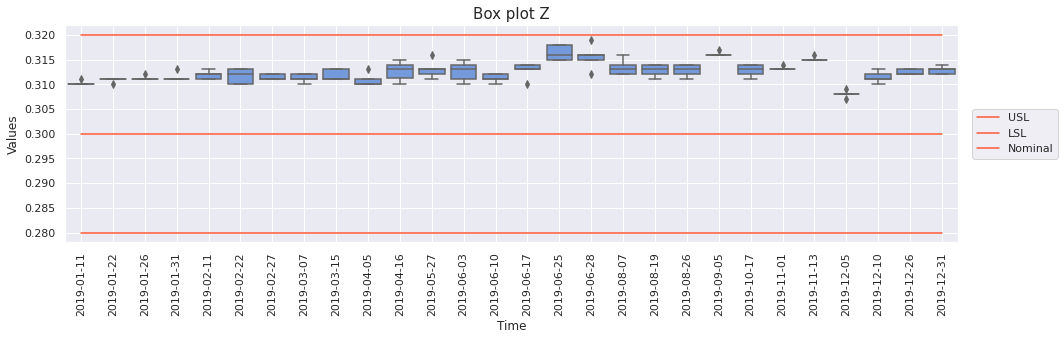

In [31]:
for name in DFdict.keys():
  df_box=DFdict[name].copy() #All values for each features
  df_box['Datef']=df_box['Datef'].dt.date
  df_box_line=df_box.groupby('Datef').mean()#Group values for line chart
  df_box_line.reset_index(inplace=True)

  fig,ax=plt.subplots(figsize=(16,4))
  sns.boxplot(x='Datef',y=name,data=df_box,ax=ax,color='cornflowerblue') 
  #df_box.boxplot(column='C-Pitch',by='Datef',ax=ax)#df_box: data with no group by date
  df_box_line.plot(y='USL',kind='line',ax=ax,color='#FF5733') #df_box_line: data with group by date
  df_box_line.plot(y='LSL',kind='line',ax=ax,color='#FF5733')
  df_box_line.plot(y='Nominal',kind='line',ax=ax,color='#FF5733')

  #plt.gca().set_xticks(df_box_line['Datef'])
  plt.gca().set_xticklabels(df_box_line['Datef'],rotation=90)
  plt.gca().set_title('Box plot '+name,fontsize=15)
  plt.gca().legend(loc ='center left',bbox_to_anchor=(1.01, 0.5))

  plt.xlabel('Time')
  plt.ylabel('Values')

In [32]:
def line_chart(DFdict_final):
    i=1
    #Layout
    fig = make_subplots(
        rows=len(DFdict_final), cols=1,
        #shared_xaxes=True,
        #vertical_spacing=0.03,
        #column_widths=[0.8, 0.2],
        subplot_titles=(list(DFdict_final.keys()))
    )
    for name in DFdict_final.keys(): #also group
      df=DFdict_final[name].copy()
      df=df.sort_values(by=['Datef'])
      for a in df.columns[1:]:
        df[a] = df[a].round(decimals=3)

      #Control chart 1 
      fig.add_trace(go.Scatter(
                              x=df['Datef'], y=df[name],
                              mode='lines+markers',
                              name='mean ' + name,line=dict( color='#4280F5')
                              ),row=i, col=1
                    )
      #USL, LSL
      fig.add_trace(go.Scatter(x=df['Datef'], y=df['USL'],name='USL '+name, line=dict( color='#FF5733')),row=i, col=1)
      fig.add_trace(go.Scatter(x=df['Datef'], y=df['LSL'],name='LSL '+name,line=dict( color='#FF5733')),row=i, col=1)
      fig.add_trace(go.Scatter(x=df['Datef'], y=df['Nominal'],name='Nominal '+name,line=dict( color='#FF5733')),row=i, col=1)
      # UCL, LCL
      fig.add_trace(go.Scatter(x=df['Datef'], y=df['UCL'],name='UCL '+name, line=dict( color='#33C2FF')),row=i, col=1)
      fig.add_trace(go.Scatter(x=df['Datef'], y=df['LCL'],name='LCL '+name, line=dict( color='#33C2FF')),row=i, col=1)
      fig.add_trace(go.Scatter(x=df['Datef'], y=df['mean'],name='mean '+name, line=dict( color='#33C2FF')),row=i, col=1)

      #Final layout:
      #fig.update_layout(height=400, width=1400, title_text='Line chart'+name)
      i=i+1

    fig.update_layout(height=300*len(DFdict_final), width=1200, title_text='Line chart')
    #fig.show()
    return fig


In [33]:
fig_new=line_chart(DFdict_final) 
fig_new

# Forecast

## Prepare data

## FBprophet

In [34]:
from fbprophet import Prophet

In [35]:
#num_predict=st.number_input("Please input number of week for prediction",value=5)
#num_predict=int(num_predict)
predict_future=5 # week

In [36]:

#@st.cache(suppress_st_warning=True)
def predict_prophet(DFdict_final):
  DF_predict_final_={} # only contail predict
  #DF_predict_all_final={} # contain predict and past value
  for name in DFdict_final.keys(): #also group
    print(name)
    df_temp_2=DFdict_final[name].copy() # gia tri mean thong thuong
    df_predict=df_temp_2.set_index(df_temp_2.columns[0]).copy()
    df_predict=df_predict.resample('1W').ffill() # gia tri mean da resample
    df_fb=df_predict.reset_index()#
    df_fb=df_fb[[df_fb.columns[0],df_fb.columns[1]]]
    df_fb.columns=['ds','y']

    # Prophet will by default fit weekly and yearly seasonalities,
    model = Prophet( #yearly_seasonality=True
                  ) #instantiate Prophet with only yearly seasonality as our data is monthly 
    model.fit(df_fb) #fit the model with your dataframe

    # predict for five months in the furure and MS - month start is the frequency
    future = model.make_future_dataframe(periods = predict_future, freq = 'W')  
    # now lets make the forecasts
    forecast = model.predict(future)
    new_forecast=forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    new_forecast['USL']=df_temp_2['USL'][0]
    new_forecast['LSL']=df_temp_2['LSL'][0]
    new_forecast['Nominal']=df_temp_2['Nominal'][0]
    new_forecast['UCL']=df_temp_2['UCL'][0]
    new_forecast['LCL']=df_temp_2['LCL'][0]
    new_forecast['mean']=df_temp_2['mean'][0]
    DF_predict_final_[name]=new_forecast 
  return DF_predict_final_
  
DF_predict_final=predict_prophet(DFdict_final)

C-Pitch


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

J


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


I


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


O


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Z


In [37]:
#@st.cache(suppress_st_warning=True,allow_output_mutation=True)
def line_chart_prophet(DFdict_final,DF_predict_final):

  i=1
  #Layout
  fig = make_subplots(
      rows=len(DFdict_final), cols=1,
      #shared_xaxes=True,
      #vertical_spacing=0.03,
      #column_widths=[0.8, 0.2],
      subplot_titles=(list(DFdict_final.keys()))
  )
  for name in DFdict_final.keys(): #also group
    df=DFdict_final[name].copy()
    df=df.sort_values(by=['Datef'])
    for a in df.columns[1:]:
      df[a] = df[a].round(decimals=3)

    #Control chart 1 
    fig.append_trace(go.Scatter(
                            x=df['Datef'], y=df[name],
                            mode='lines+markers',
                            name='mean ' + name,line=dict( color='#4280F5')
                            ),row=i, col=1
                  )
    #Predict:
    df_predict=DF_predict_final[name].copy()
    fig.append_trace(go.Scatter(
                        x=df_predict['ds'], y=df_predict['yhat'],
                        mode='lines+markers',
                        name='mean predict ' + name,line=dict( color='#060891')
                        ),row=i, col=1
              )

    #USL, LSL
    fig.append_trace(go.Scatter(x=df_predict['ds'], y=df_predict['USL'],name='USL '+name, line=dict( color='#FF5733')),row=i, col=1)
    fig.append_trace(go.Scatter(x=df_predict['ds'], y=df_predict['LSL'],name='LSL '+name,line=dict( color='#FF5733')),row=i, col=1)
    fig.append_trace(go.Scatter(x=df_predict['ds'], y=df_predict['Nominal'],name='Nominal '+name,line=dict( color='#FF5733')),row=i, col=1)
    # UCL, LCL
    fig.append_trace(go.Scatter(x=df_predict['ds'], y=df_predict['UCL'],name='UCL '+name, line=dict( color='#33C2FF')),row=i, col=1)
    fig.append_trace(go.Scatter(x=df_predict['ds'], y=df_predict['LCL'],name='LCL '+name, line=dict( color='#33C2FF')),row=i, col=1)
    fig.append_trace(go.Scatter(x=df_predict['ds'], y=df_predict['mean'],name='mean '+name, line=dict( color='#33C2FF')),row=i, col=1)
    # Fill between:
    fig.append_trace(go.Scatter(x=df_predict['ds'], y=df_predict['yhat_upper'],name='yhat_upper '+name, line=dict( color='#9FA0F8'),fill=None),row=i, col=1)
    fig.append_trace(go.Scatter(x=df_predict['ds'], y=df_predict['yhat_lower'],name='yhat_lower '+name, line=dict( color='#9FA0F8'), fill='tonexty'),row=i, col=1)


    #Final layout:
    #fig.update_layout(height=400, width=1400, title_text='Line chart'+name)
    i=i+1
    
  fig.update_layout(height=300*len(DFdict_final), width=1200, title_text='Line chart')
  #fig.show()
  return fig
fig_new_2=line_chart_prophet(DFdict_final,DF_predict_final)
fig_new_2.show()
#st.plotly_chart(fig_new)

In [38]:
#------------------Save Line chart plotly-----------------------------------------#


#if st.checkbox('Save predict Line chart'):
#if st.button("Save Line chart"):
#    fig_new_2.write_html(path3+namefile+'_predict_line.html')
#    st.write('Path file: ',path3+namefile+'_predict_line.html')
#----------------------------Box chart altair----------------------------------------#

### Validate Prophet

In [39]:
# Python
from fbprophet import Prophet
from fbprophet.plot import plot_plotly
import plotly.offline as py
#py.init_notebook_mode()

In [42]:
DF_predict_final_={} # only contain predict test with y predict and y_true
for name in DFdict_final.keys(): #also group
  print(name)
  df_temp_2=DFdict_final[name].copy() # gia tri mean thong thuong
  df_predict=df_temp_2.set_index(df_temp_2.columns[0]).copy()
  df_predict=df_predict.resample('1W').ffill() # gia tri mean da resample
  df_fb=df_predict.reset_index()#
  df_fb=df_fb[[df_fb.columns[0],df_fb.columns[1]]]
  df_fb.columns=['ds','y']
  # split train and test set
  split=int(len(df_fb) * 0.80)
  training_set=df_fb[:split]
  test_set=df_fb[split:]
  #define predict future (test_set)
  predict_future=len(test_set)
  # Prophet will by default fit weekly and yearly seasonalities,
  model = Prophet( #yearly_seasonality=True
                ) #instantiate Prophet with only yearly seasonality as our data is monthly 
  model.fit(training_set) #fit the model with your dataframe

  # predict for five months in the furure and MS - month start is the frequency
  future = model.make_future_dataframe(periods = predict_future, freq = 'W')  
  # now lets make the forecasts
  forecast = model.predict(future)
  new_forecast=forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
  new_forecast['USL']=df_temp_2['USL'][0]
  new_forecast['LSL']=df_temp_2['LSL'][0]
  new_forecast['Nominal']=df_temp_2['Nominal'][0]
  new_forecast['UCL']=df_temp_2['UCL'][0]
  new_forecast['LCL']=df_temp_2['LCL'][0]
  new_forecast['mean']=df_temp_2['mean'][0]
  new_forecast=new_forecast[split:]
  join_data=pd.merge(new_forecast,test_set,how='inner',left_on='ds',right_on='ds')
  DF_predict_final_[name]=join_data #only contain predict test with y predict and y_true


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


C-Pitch


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

J


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


I


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


O


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Z


In [43]:
i=1
#Layout
fig = make_subplots(
    rows=len(DF_predict_final_), cols=1,
    subplot_titles=(list(DFdict_final.keys()))
)
for name in DF_predict_final_.keys(): #also group

  df=DF_predict_final_[name].copy()
  df=df.sort_values(by=['ds'])
  for a in df.columns[1:]:
    df[a] = df[a].round(decimals=3)
  print(name)
  print('test rmse:', np.sqrt(mean_squared_error(df['y'], df['yhat'])))
  print('test mae:', np.sqrt(mean_absolute_error(df['y'], df['yhat'])))

  #Control chart 1 and predict is the same dataframe
  fig.append_trace(go.Scatter(
                          x=df['ds'], y=df['y'],
                          mode='lines+markers',
                          name='mean ' + name,line=dict( color='#000000')
                          ),row=i, col=1
                )
  #Predict:
  df_predict=df
  fig.append_trace(go.Scatter(
                      x=df_predict['ds'], y=df_predict['yhat'],
                      mode='lines+markers',
                      name='mean predict ' + name,line=dict( color='#ff25e2')
                      ),row=i, col=1
            )

  #USL, LSL
  fig.append_trace(go.Scatter(x=df_predict['ds'], y=df_predict['USL'],name='USL '+name, line=dict( color='#FF5733'),mode='lines'),row=i, col=1)
  fig.append_trace(go.Scatter(x=df_predict['ds'], y=df_predict['LSL'],name='LSL '+name,line=dict( color='#FF5733'),mode='lines'),row=i, col=1)
  #fig.append_trace(go.Scatter(x=df_predict['ds'], y=df_predict['Nominal'],name='Nominal '+name,line=dict( color='#FF5733'),mode='lines'),row=i, col=1)
  # UCL, LCL
  #fig.append_trace(go.Scatter(x=df_predict['ds'], y=df_predict['UCL'],name='UCL '+name, line=dict( color='#33C2FF'),mode='lines'),row=i, col=1)
  #fig.append_trace(go.Scatter(x=df_predict['ds'], y=df_predict['LCL'],name='LCL '+name, line=dict( color='#33C2FF'),mode='lines'),row=i, col=1)
  #fig.append_trace(go.Scatter(x=df_predict['ds'], y=df_predict['mean'],name='mean '+name, line=dict( color='#33C2FF'),mode='lines'),row=i, col=1)
  # Fill between:
  fig.append_trace(go.Scatter(x=df_predict['ds'], y=df_predict['yhat_upper'],name='yhat_upper '+name, line=dict( color='#9FA0F8'),fill=None,mode='lines'),row=i, col=1)
  fig.append_trace(go.Scatter(x=df_predict['ds'], y=df_predict['yhat_lower'],name='yhat_lower '+name, line=dict( color='#9FA0F8'), fill='tonexty',mode='lines'),row=i, col=1)
  i+=1
fig.update_layout(height=300*len(DFdict_final), width=1200, title_text='Line chart')
fig.show()

C-Pitch
test rmse: 0.0015954480704351605
test mae: 0.03567530340063522
J
test rmse: 0.0013483997249264556
test mae: 0.033028912953789916
I
test rmse: 0.002000000000000103
test mae: 0.042640143271123525
O
test rmse: 0.007639609699692028
test mae: 0.08633970960424221
Z
test rmse: 0.004512608598542134
test mae: 0.061791438065332494


## ARIMA

In [44]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
import scipy.stats as scs
from math import sqrt
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler

In [45]:
for name in DFdict_final.keys(): #also group
  print(name)
  df_temp_2=DFdict_final[name].copy() # gia tri mean thong thuong
  df_predict=df_temp_2.set_index(df_temp_2.columns[0]).copy()
  df_predict=df_predict.resample('1W').ffill() # gia tri mean da resample
  df_original=df_predict.reset_index()#
  #df_lstm=df_lstm[[df_lstm.columns[0],df_lstm.columns[1]]]
  #df_fb.columns=['ds','y']
  break
df=df_original[[df_original.columns[0],df_original.columns[1]]].\
    set_index(df_original.columns[0])
df.head()

C-Pitch


,C-Pitch
Datef,
2019-01-13,10.004
2019-01-20,10.004
2019-01-27,10.002
2019-02-03,10.003
2019-02-10,10.003


By setting the parameters of the ARIMA model, we can obtain some
special cases:
- ARIMA (0,0,0): White noise
- ARIMA (0,1,0) without constant: Random walk
- ARIMA (p,0,q): ARMA(p, q)
- ARIMA (p, 0, 0): AR(p) model
- ARIMA (0, 0, q): MA(q) model
- ARIMA (0,1,2): Damped Holt's model
- ARIMA (0,1,1) without constant: SES model
- ARIMA (0,2,2): Holt's linear method with additive errors

In [46]:
order=(0,1,1)

In [47]:
# Define important value
split=int(len(df) * 0.80)
training_set=df[:split][df.columns[0]] 
test_set=df[split:][df.columns[0]] 
y_test=test_set # y test
print(training_set.shape)
print(test_set.shape)

(41,)
(11,)


In [48]:
history = [x for x in training_set]
predictions = list()
for i in range(len(test_set)):
  # predict
  model = ARIMA(history, order=order)
  model_fit = model.fit(disp=0)
  yhat = model_fit.forecast()[0]
  predictions.append(yhat)
  # observation
  obs = test_set[i]
  history.append(obs)
  #print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test_set, predictions))
predictions_series=pd.Series((v[0] for v in predictions))
mae=mean_absolute_error(test_set,predictions_series)

print('RMSE: %.3f' % rmse)
print('MAE: %.3f' % mae)

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



RMSE: 0.002
MAE: 0.001


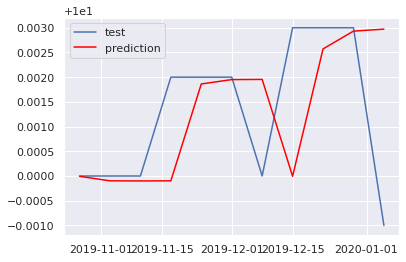

In [49]:
predictions_frame=predictions_series.to_frame()
predictions_frame.index=test_set.to_frame().index
test_set_frame=test_set.to_frame()
plt.plot(test_set_frame,label='test')
plt.plot(predictions_frame, color='red',label='prediction')
plt.legend()
plt.show()

### Combine to one

In [50]:
#num_predict=st.number_input("Please input number of week for prediction",value=5)
#num_predict=int(num_predict)
n_forecasts=10 # week

In [51]:

n_forecasts=10 # week
#@st.cache(suppress_st_warning=True)
def predict_prophet(DFdict_final):
  DF_predict_final_={} # only contail predict
  #DF_predict_all_final={} # contain predict and past value
  for name in DFdict_final.keys(): #also group
    print(name)
    df_temp_2=DFdict_final[name].copy() # gia tri mean thong thuong
    df_temp_2=df_temp_2.set_index(df_temp_2.columns[0]).copy()
    df_temp_2=df_temp_2.resample('1W').ffill() # gia tri mean da resample
    df_original=df_temp_2.reset_index()#

    df=df_original[[df_original.columns[0],df_original.columns[1]]].\
      set_index(df_original.columns[0])

    # Prophet will by default fit weekly and yearly seasonalities,
    arima = ARIMA(df, order=(0, 1, 1)).fit(disp=0)
   
    arima_pred = arima.forecast(n_forecasts) # arima manual select 

    arima_pred = pd.concat([pd.DataFrame(arima_pred[0], columns=['prediction']),
                          pd.DataFrame(arima_pred[2], columns=['ci_lower','ci_upper'])],axis=1)
    x=df[-1:].index.astype(np.int64) // 10 ** 9
    timestamp = datetime.datetime.fromtimestamp(x.values)
    a=timestamp.strftime('%Y-%m-%d')
    didx = pd.date_range(start =a, freq ='W',periods = n_forecasts) 
    arima_pred.index=didx
    arima_pred['USL']=df_original['USL'][0]
    arima_pred['LSL']=df_original['LSL'][0]
    arima_pred['Nominal']=df_original['Nominal'][0]
    arima_pred['UCL']=df_original['UCL'][0]
    arima_pred['LCL']=df_original['LCL'][0]
    arima_pred['mean']=df_original['mean'][0]
    DF_predict_final_[name]=arima_pred 
  return DF_predict_final_
  
DF_predict_final=predict_prophet(DFdict_final)

C-Pitch
J
I
O


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was pro

Z


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



In [52]:
#@st.cache(suppress_st_warning=True,allow_output_mutation=True)
def line_chart_prophet(DFdict_final,DF_predict_final):

  i=1
  #Layout
  fig = make_subplots(
      rows=len(DFdict_final), cols=1,
      #shared_xaxes=True,
      #vertical_spacing=0.03,
      #column_widths=[0.8, 0.2],
      subplot_titles=(list(DFdict_final.keys()))
  )
  for name in DFdict_final.keys(): #also group
    df=DFdict_final[name].copy()
    df=df.sort_values(by=['Datef'])
    for a in df.columns[1:]:
      df[a] = df[a].round(decimals=3)

    #Control chart 1 
    fig.append_trace(go.Scatter(
                            x=df['Datef'], y=df[name],
                            mode='lines+markers',
                            name='mean ' + name,line=dict( color='#4280F5')
                            ),row=i, col=1
                  )
    #USL, LSL
    fig.append_trace(go.Scatter(x=df['Datef'], y=df['USL'],name='USL '+name, line=dict( color='#FF5733')),row=i, col=1)
    fig.append_trace(go.Scatter(x=df['Datef'], y=df['LSL'],name='LSL '+name,line=dict( color='#FF5733')),row=i, col=1)
    fig.append_trace(go.Scatter(x=df['Datef'], y=df['Nominal'],name='Nominal '+name,line=dict( color='#FF5733')),row=i, col=1)
    # UCL, LCL
    fig.append_trace(go.Scatter(x=df['Datef'], y=df['UCL'],name='UCL '+name, line=dict( color='#33C2FF')),row=i, col=1)
    fig.append_trace(go.Scatter(x=df['Datef'], y=df['LCL'],name='LCL '+name, line=dict( color='#33C2FF')),row=i, col=1)
    fig.append_trace(go.Scatter(x=df['Datef'], y=df['mean'],name='mean '+name, line=dict( color='#33C2FF')),row=i, col=1)

    #Predict:
    df_predict=DF_predict_final[name].copy()
    fig.append_trace(go.Scatter(
                        x=df_predict.index, y=df_predict.prediction,
                        mode='lines+markers',
                        name='mean predict ' + name,line=dict( color='#060891')
                        ),row=i, col=1
              )

    #USL, LSL
    fig.append_trace(go.Scatter(x=df_predict.index, y=df_predict['USL'],name='USL '+name, line=dict( color='#FF5733'),mode='lines'),row=i, col=1)
    fig.append_trace(go.Scatter(x=df_predict.index, y=df_predict['LSL'],name='LSL '+name,line=dict( color='#FF5733'),mode='lines'),row=i, col=1)
    fig.append_trace(go.Scatter(x=df_predict.index, y=df_predict['Nominal'],name='Nominal '+name,line=dict( color='#FF5733'),mode='lines'),row=i, col=1)
    # UCL, LCL
    fig.append_trace(go.Scatter(x=df_predict.index, y=df_predict['UCL'],name='UCL '+name, line=dict( color='#33C2FF'),mode='lines'),row=i, col=1)
    fig.append_trace(go.Scatter(x=df_predict.index, y=df_predict['LCL'],name='LCL '+name, line=dict( color='#33C2FF'),mode='lines'),row=i, col=1)
    fig.append_trace(go.Scatter(x=df_predict.index, y=df_predict['mean'],name='mean '+name, line=dict( color='#33C2FF'),mode='lines'),row=i, col=1)
    # Fill between:
    fig.append_trace(go.Scatter(x=df_predict.index, y=df_predict['ci_upper'],name='yhat_upper '+name, line=dict( color='#9FA0F8'),fill=None,mode='lines'),row=i, col=1)
    fig.append_trace(go.Scatter(x=df_predict.index, y=df_predict['ci_lower'],name='yhat_lower '+name, line=dict( color='#9FA0F8'), fill='tonexty',mode='lines'),row=i, col=1)


    #Final layout:
    #fig.update_layout(height=400, width=1400, title_text='Line chart'+name)
    i=i+1
    
  fig.update_layout(height=300*len(DFdict_final), width=1200, title_text='Line chart')
  #fig.show()
  return fig
fig_new_2=line_chart_prophet(DFdict_final,DF_predict_final)
fig_new_2.show()
#st.plotly_chart(fig_new)

In [53]:
#------------------Save Line chart plotly-----------------------------------------#


#if st.checkbox('Save predict Line chart'):
#if st.button("Save Line chart"):
#    fig_new_2.write_html(path3+namefile+'_predict_line.html')
#    st.write('Path file: ',path3+namefile+'_predict_line.html')
#----------------------------Box chart altair----------------------------------------#

### ARIMA validate

In [54]:

DF_predict_final_={} # only contail predict
#DF_predict_all_final={} # contain predict and past value
for name in DFdict_final.keys(): #also group
  #print(name)
  df_temp_2=DFdict_final[name].copy() # gia tri mean thong thuong
  df_temp_2=df_temp_2.set_index(df_temp_2.columns[0]).copy()
  df_temp_2=df_temp_2.resample('1W').ffill() # gia tri mean da resample
  df_original=df_temp_2.reset_index()#

  df=df_original[[df_original.columns[0],df_original.columns[1]]].\
    set_index(df_original.columns[0])
  split=int(len(df) * 0.80)
  training_set=df[:split]
  test_set=df[split:]
  predict_future=len(test_set)

  arima = ARIMA(training_set, order=(0, 1, 1)).fit(disp=0)   
  arima_pred = arima.forecast(predict_future) # arima manual select 
  arima_pred = pd.concat([pd.DataFrame(arima_pred[0], columns=['prediction']),
                        pd.DataFrame(arima_pred[2], columns=['ci_lower','ci_upper'])],axis=1)
  x=test_set[:1].index.astype(np.int64) // 10 ** 9
  timestamp = datetime.datetime.fromtimestamp(x.values)
  a=timestamp.strftime('%Y-%m-%d')
  didx = pd.date_range(start =a, freq ='W',periods = predict_future) 
  arima_pred.index=didx
  arima_pred['USL']=df_original['USL'][0]
  arima_pred['LSL']=df_original['LSL'][0]
  arima_pred['Nominal']=df_original['Nominal'][0]
  arima_pred['UCL']=df_original['UCL'][0]
  arima_pred['LCL']=df_original['LCL'][0]
  arima_pred['mean']=df_original['mean'][0]
  arima_pred=arima_pred.reset_index()
  test_set=test_set.reset_index()
  join_data=pd.merge(arima_pred,test_set,how='inner',left_on='index',right_on='Datef')
  join_data=join_data.drop(columns='Datef')
  DF_predict_final_[name]=join_data
#DF_predict_final_


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was pro

In [55]:
join_data.head()

,index,prediction,ci_lower,ci_upper,USL,LSL,Nominal,UCL,LCL,mean,Z
0,2019-10-27,0.312868,0.310619,0.315117,0.32,0.28,0.3,0.317891,0.306895,0.312393,0.313
1,2019-11-03,0.312938,0.309651,0.316225,0.32,0.28,0.3,0.317891,0.306895,0.312393,0.313
2,2019-11-10,0.313008,0.308940,0.317076,0.32,0.28,0.3,0.317891,0.306895,0.312393,0.313
3,2019-11-17,0.313077,0.308356,0.317799,0.32,0.28,0.3,0.317891,0.306895,0.312393,0.315
4,2019-11-24,0.313147,0.307852,0.318442,0.32,0.28,0.3,0.317891,0.306895,0.312393,0.315


In [56]:
i=1
#Layout
fig = make_subplots(
    rows=len(DF_predict_final_), cols=1,
    subplot_titles=(list(DFdict_final.keys()))
)
for name in DF_predict_final_.keys(): #also group

  df=DF_predict_final_[name].copy()
  df=df.sort_values(by=['index'])
  for a in df.columns[1:]:
    df[a] = df[a].round(decimals=3)
  print(name)
  print('test rmse:', np.sqrt(mean_squared_error(df[name], df['prediction'])))
  print('test mae:', np.sqrt(mean_absolute_error(df[name], df['prediction'])))

  #Control chart 1 and predict is the same dataframe
  fig.append_trace(go.Scatter(
                          x=df['index'], y=df[name],
                          mode='lines+markers',
                          name='mean ' + name,line=dict( color='#000000')
                          ),row=i, col=1
                )
  #Predict:
  df_predict=df
  fig.append_trace(go.Scatter(
                      x=df_predict['index'], y=df_predict['prediction'],
                      mode='lines+markers',
                      name='mean predict ' + name,line=dict( color='#ff25e2')
                      ),row=i, col=1
            )

  #USL, LSL
  fig.append_trace(go.Scatter(x=df_predict['index'], y=df_predict['USL'],name='USL '+name, line=dict( color='#FF5733'),mode='lines'),row=i, col=1)
  fig.append_trace(go.Scatter(x=df_predict['index'], y=df_predict['LSL'],name='LSL '+name,line=dict( color='#FF5733'),mode='lines'),row=i, col=1)
  #fig.append_trace(go.Scatter(x=df_predict['ds'], y=df_predict['Nominal'],name='Nominal '+name,line=dict( color='#FF5733'),mode='lines'),row=i, col=1)
  # UCL, LCL
  #fig.append_trace(go.Scatter(x=df_predict['ds'], y=df_predict['UCL'],name='UCL '+name, line=dict( color='#33C2FF'),mode='lines'),row=i, col=1)
  #fig.append_trace(go.Scatter(x=df_predict['ds'], y=df_predict['LCL'],name='LCL '+name, line=dict( color='#33C2FF'),mode='lines'),row=i, col=1)
  #fig.append_trace(go.Scatter(x=df_predict['ds'], y=df_predict['mean'],name='mean '+name, line=dict( color='#33C2FF'),mode='lines'),row=i, col=1)
  # Fill between:
  fig.append_trace(go.Scatter(x=df_predict['index'], y=df_predict['ci_upper'],name='ci_upper '+name, line=dict( color='#9FA0F8'),fill=None,mode='lines'),row=i, col=1)
  fig.append_trace(go.Scatter(x=df_predict['index'], y=df_predict['ci_lower'],name='ci_lower '+name, line=dict( color='#9FA0F8'), fill='tonexty',mode='lines'),row=i, col=1)
  i+=1
fig.update_layout(height=300*len(DFdict_final), width=1200, title_text='Line chart')
fig.show()

C-Pitch
test rmse: 0.0023548788812705872
test mae: 0.04156047072968182
J
test rmse: 0.0009045340337332358
test mae: 0.02522624895547466
I
test rmse: 0.002828427124746207
test mae: 0.05045249791095133
O
test rmse: 0.0018586407545692696
test mae: 0.03567530340063522
Z
test rmse: 0.0020670576365276515
test mae: 0.039312269655344845


## LSTM predict

In [57]:
# univariate mlp example
import warnings
from numpy import array
import matplotlib.pyplot as plt
from keras import optimizers
from keras import backend
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten,Bidirectional
from keras.optimizers import Adam
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from keras.regularizers import l1
from keras.regularizers import l2
from keras.regularizers import l1_l2
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers import Dense
from keras.metrics import categorical_crossentropy

from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler

### Many to one (split train/test)

In [58]:
# Some functions to help out with
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='test set')
    plt.plot(predicted, color='blue',label='Predicted set')
    plt.title('Prediction')
    plt.xlabel('Time')
    plt.ylabel('Prediction')
    plt.legend()
    plt.show()

In [59]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [60]:
def model_lstm1(n_steps_in,n_steps_out): 
  n_features=1
  def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))
  # define model
  model = Sequential()
  model.add(LSTM(50, activation='relu', #return_sequences=True, 
                 input_shape=(n_steps_in, n_features)))
  #model.add(LSTM(100, activation='relu'))
  model.add(Dense(n_steps_out))
  model.compile(optimizer='adam', loss='mse',metrics=['mse','mae','mape',rmse])
  #model.summary()
  return model

In [61]:
def model_lstm2(n_steps_in,n_steps_out): 
  n_features=1
  def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))
  # define model
  model = Sequential()
  model.add(Bidirectional(LSTM(100,dropout=0.2, activation='relu',return_sequences=True), input_shape=(n_steps_in, n_features)))
  model.add(Bidirectional(LSTM(100, dropout=0.2, activation='relu', return_sequences=True)))
  #model.add(LSTM(100, activation='relu',return_sequences=True))
  model.add(Dense(n_steps_out))
  model.compile(optimizer='adam', loss='mse',metrics=['mse','mae','mape',rmse])
  #model.summary()
  return model

In [64]:
split_number=0.80
n_steps_in  = 7
n_steps_out = 1
model= model_lstm1(n_steps_in,n_steps_out)
model_name='model_lstm1'

In [68]:
DF_predict_final_test={}
DF_predict_final_train={}
for name in DFdict_final.keys(): #also group

  # choose a number of time steps
  print(name)
  df_temp_2=DFdict_final[name].copy() # gia tri mean thong thuong
  df_temp_2=df_temp_2.set_index(df_temp_2.columns[0]).copy()
  df_temp_2=df_temp_2.resample('1W').ffill() # gia tri mean da resample
  df_original=df_temp_2.reset_index()#
  df=df_original[[df_original.columns[0],df_original.columns[1]]].\
                              set_index(df_original.columns[0])
  # Define important value
  split=int(len(df) * split_number)
  training_set=df[:split]
  test_set=df[split:]
  predict_future=len(test_set)
  #prepare training set
  X_train, y_train = split_sequence(training_set[name], n_steps_in, n_steps_out)
  n_features = 1
  X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
  print(X_train.shape)
  print(y_train.shape)
  #prepare test set
  inputs=df[name][len(df)-len(test_set) - n_steps_in:]
  X_test, y_test = split_sequence(inputs, n_steps_in, n_steps_out)
  X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
  print(X_test.shape)
  print(y_test.shape)
  # Fitting to the training set
  #callbacks = [EarlyStopping(monitor="val_loss", patience=3, mode='min',restore_best_weights=True)]
  history=model.fit(X_train,y_train,validation_split=0.2,epochs=500,verbose=0,#callbacks=callbacks
                    )
  y_train_pred=model.predict(X_train)
  y_test_pred=model.predict(X_test)
  print('train rmse:', np.sqrt(mean_squared_error(y_train, y_train_pred)))
  print('test rmse:', np.sqrt(mean_squared_error(y_test, y_test_pred)))
  print('train mae:', np.sqrt(mean_absolute_error(y_train, y_train_pred)))
  print('test mae:', np.sqrt(mean_absolute_error(y_test, y_test_pred)))

  # Join test set and test predict:
  y_test_pred_df=pd.DataFrame(y_test_pred)
  y_test_pred_df.columns=[name+'_predict']
  y_test_pred_df.index=test_set.index
  y_test_pred_df['USL']=df_original['USL'][0]
  y_test_pred_df['LSL']=df_original['LSL'][0]
  y_test_pred_df['Nominal']=df_original['Nominal'][0]
  y_test_pred_df['UCL']=df_original['UCL'][0]
  y_test_pred_df['LCL']=df_original['LCL'][0]
  y_test_pred_df['mean']=df_original['mean'][0]
  y_test_pred_df=y_test_pred_df.reset_index()
  test_set_new=test_set.reset_index()
  #test_set_new.columns=['Datef',name+'_predict']
  join_data_test=pd.merge(y_test_pred_df,test_set_new,how='inner',left_on='Datef',right_on='Datef')
  DF_predict_final_test[name]=join_data_test

  # Join train set and train predict:
  y_train_pred_df=pd.DataFrame(y_train_pred)
  y_train_pred_df.columns=[name+'_predict']
  y_train_pred_df.index=training_set[n_steps_in:].index
  y_train_pred_df['USL']=df_original['USL'][0]
  y_train_pred_df['LSL']=df_original['LSL'][0]
  y_train_pred_df['Nominal']=df_original['Nominal'][0]
  y_train_pred_df['UCL']=df_original['UCL'][0]
  y_train_pred_df['LCL']=df_original['LCL'][0]
  y_train_pred_df['mean']=df_original['mean'][0]
  y_train_pred_df=y_train_pred_df.reset_index()
  training_set_new=training_set[n_steps_in:].reset_index()
  #test_set_new.columns=['Datef',name+'_predict']
  join_data_train=pd.merge(y_train_pred_df,training_set_new,how='inner',left_on='Datef',right_on='Datef')
  DF_predict_final_train[name]=join_data_train

C-Pitch
(34, 7, 1)
(34, 1)
(11, 7, 1)
(11, 1)
train rmse: 0.00218870941858668
test rmse: 0.001991475052724084
train mae: 0.041344822441986624
test mae: 0.042713983560961795
J
(34, 7, 1)
(34, 1)
(11, 7, 1)
(11, 1)
train rmse: 0.0007636473153542799
test rmse: 0.0009227546001815256
train mae: 0.025188758369875195
test mae: 0.02659931100512226
I
(34, 7, 1)
(34, 1)
(11, 7, 1)
(11, 1)
train rmse: 0.0015715015684814582
test rmse: 0.002294121051843467
train mae: 0.0344540597687831
test mae: 0.046674210033687207
O
(34, 7, 1)
(34, 1)
(11, 7, 1)
(11, 1)
train rmse: 0.00279228172161305
test rmse: 0.002614626725557477
train mae: 0.04656889897474936
test mae: 0.046245124428692
Z
(34, 7, 1)
(34, 1)
(11, 7, 1)
(11, 1)
train rmse: 0.0014515807183486569
test rmse: 0.0023558184451100373
train mae: 0.0355513674283592
test mae: 0.04169233707577995


In [69]:
i=1
#Layout
fig = make_subplots(
     rows=len(DF_predict_final_), cols=1,
    subplot_titles=(list(DFdict_final.keys()))
)

for name in DF_predict_final_test.keys(): #also group

  df_test=DF_predict_final_test[name].copy()
  df_test=df_test.sort_values(by=['Datef'])
  for a in df_test.columns[1:]:
    df_test[a] = df_test[a].round(decimals=3)
  print(name)
  print('test rmse:', np.sqrt(mean_squared_error(df_test[name], df_test[df_test.columns[1]])))
  print('test mae:', np.sqrt(mean_absolute_error(df_test[name], df_test[df_test.columns[1]])))

  #Control chart 1 for test set
  fig.append_trace(go.Scatter(
                          x=df_test['Datef'], y=df_test[name],
                          mode='lines+markers',
                          name='mean ' + name,line=dict( color='#000000')
                          ),row=i, col=1
                )
  #Predict:
  fig.append_trace(go.Scatter(
                      x=df_test['Datef'], y=df_test[df_test.columns[1]],
                      mode='lines+markers',
                      name='mean predict ' + name,line=dict( color='#ff25e2')
                      ),row=i, col=1
            )
  #USL, LSL
  fig.append_trace(go.Scatter(x=df_test['Datef'], y=df_test['USL'],name='USL '+name, line=dict( color='#FF5733'),mode='lines'),row=i, col=1)
  fig.append_trace(go.Scatter(x=df_test['Datef'], y=df_test['LSL'],name='LSL '+name,line=dict( color='#FF5733'),mode='lines'),row=i, col=1)
  #fig.append_trace(go.Scatter(x=df_predict['ds'], y=df_predict['Nominal'],name='Nominal '+name,line=dict( color='#FF5733'),mode='lines'),row=i, col=1)

  #Control chart 2 for train set
  df_train=DF_predict_final_train[name].copy()
  df_train=df_train.sort_values(by=['Datef'])
  for a in df_train.columns[1:]:
    df_train[a] = df_train[a].round(decimals=3)
  fig.append_trace(go.Scatter(
                          x=df_train['Datef'], y=df_train[name],
                          mode='lines+markers',
                          name='mean ' + name,line=dict( color='#000000')
                          ),row=i, col=1
                )
  #Predict:
  fig.append_trace(go.Scatter(
                      x=df_train['Datef'], y=df_train[df_train.columns[1]],
                      mode='lines+markers',
                      name='mean predict ' + name,line=dict( color='#ff25e2')
                      ),row=i, col=1
            )
  #USL, LSL
  fig.append_trace(go.Scatter(x=df_train['Datef'], y=df_train['USL'],name='USL '+name, line=dict( color='#FF5733'),mode='lines'),row=i, col=1)
  fig.append_trace(go.Scatter(x=df_train['Datef'], y=df_train['LSL'],name='LSL '+name,line=dict( color='#FF5733'),mode='lines'),row=i, col=1)
  #fig.append_trace(go.Scatter(x=df_predict['ds'], y=df_predict['Nominal'],name='Nominal '+name,line=dict( color='#FF5733'),mode='lines'),row=i, col=1)
  i+=1
fig.update_layout(height=300*len(DF_predict_final_test), width=1200, title_text='Line chart')
fig.write_html('LSTM in:'+model_name+'_'+str(n_steps_in) +' out:' +str(n_steps_out)+ '_line.html')
fig.show()

C-Pitch
test rmse: 0.0021105482042606725
test mae: 0.04369326392947644
J
test rmse: 0.0009045285707013797
test mae: 0.02522641220312258
I
test rmse: 0.002236081936413664
test mae: 0.0457265485302535
O
test rmse: 0.002645612130458892
test mae: 0.04572571617743964
Z
test rmse: 0.002276360741454031
test mae: 0.04156043996027481


### ***Investigate LSTM (data from Sonion)

#### Many to one (already applied above)

In [70]:
from keras.utils.vis_utils import plot_model

In [71]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [72]:
df=DFdict_final['C-Pitch'][['Datef','C-Pitch']].set_index('Datef')
df=df['C-Pitch']
df.head()

Datef
2019-01-11    10.004
2019-01-22    10.001
2019-01-26    10.002
2019-01-31    10.003
2019-02-11    10.003
Name: C-Pitch, dtype: float64

In [ ]:
split_number=0.80
n_steps_in  = 7
n_steps_out = 1
n_features=1
split=int(len(df) * split_number)
training_set=df[:split]
test_set=df[split:]
predict_future=len(test_set)
#prepare training set
X_train, y_train = split_sequence(training_set, n_steps_in, n_steps_out)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
print(X_train.shape)
print(y_train.shape)
#prepare test set
inputs=df[len(df)-len(test_set) - n_steps_in:]
X_test, y_test = split_sequence(inputs, n_steps_in, n_steps_out)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
print(X_test.shape)
print(y_test.shape)

(15, 7, 1)
(15, 1)
(6, 7, 1)
(6, 1)


No return sequence

train rmse: 0.0016359106942016694
test rmse: 0.002566690857210863


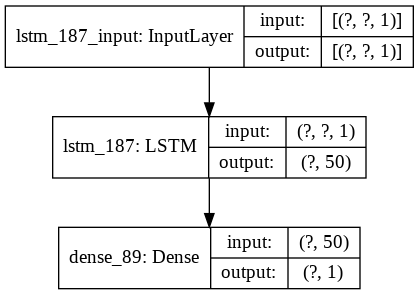

In [ ]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(None, 1))) # 7 timesteps, 1 feature
model.add(Dense(1)) # one timestep
model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, y_train, epochs=500, validation_split=0.2, verbose=0)
y_train_pred=model.predict(X_train)
y_test_pred=model.predict(X_test)
print('train rmse:', np.sqrt(mean_squared_error(y_train, y_train_pred)))
print('test rmse:', np.sqrt(mean_squared_error(y_test, y_test_pred)))
plot_model(model, show_shapes=True, show_layer_names=True)

Return sequence

train rmse: 0.003076722663278182
test rmse: 0.001746503990740775


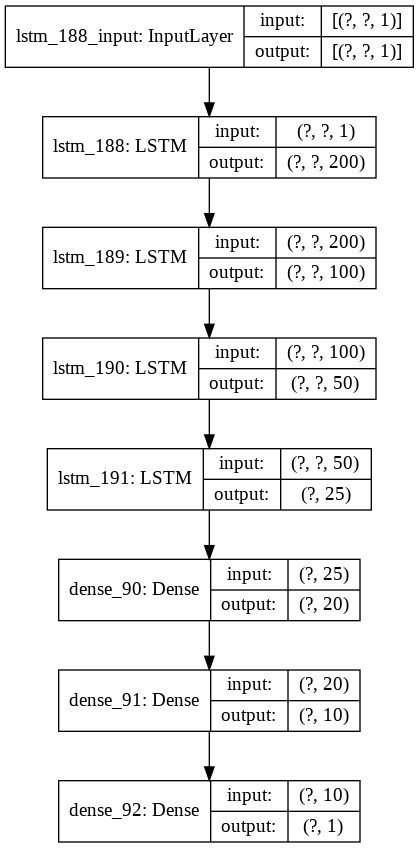

In [ ]:
model = Sequential()
model.add(LSTM(200, activation='relu', return_sequences=True, input_shape=(None, 1))) #inputshape: n_steps_in , return 7 timesteps for next stack
model.add(LSTM(100, activation='relu', return_sequences=True)) # return 7 timesteps for next stack
model.add(LSTM(50,  activation='relu', return_sequences=True)) # return 7 timesteps for next stack
model.add(LSTM(25,  activation='relu')) # return only 1 for dens layer
model.add(Dense(20, activation='relu')) 
model.add(Dense(10, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, y_train, epochs=500, validation_split=0.2, verbose=0)
y_train_pred=model.predict(X_train)
y_test_pred=model.predict(X_test)
print('train rmse:', np.sqrt(mean_squared_error(y_train, y_train_pred)))
print('test rmse:', np.sqrt(mean_squared_error(y_test, y_test_pred)))
plot_model(model, show_shapes=True, show_layer_names=True)

#### One to many

In [113]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [114]:
df=DFdict_final['C-Pitch'][['Datef','C-Pitch']].set_index('Datef')
df=df['C-Pitch']
df.head()

Datef
2019-01-11    10.004
2019-01-22    10.001
2019-01-26    10.002
2019-01-31    10.003
2019-02-11    10.003
Name: C-Pitch, dtype: float64

In [115]:
split_number=0.80
n_steps_in  = 1
n_steps_out = 5
n_features=1
split=int(len(df) * split_number)
training_set=df[:split]
test_set=df[split:]
predict_future=len(test_set)
#prepare training set
X_train, y_train = split_sequence(training_set, n_steps_in, n_steps_out)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
print(X_train.shape)
print(y_train.shape)
#prepare test set
inputs=df[len(df)-len(test_set) - n_steps_in:]
X_test, y_test = split_sequence(inputs, n_steps_in, n_steps_out)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
print(X_test.shape)
print(y_test.shape)

(17, 1, 1)
(17, 5)
(2, 1, 1)
(2, 5)


train rmse: 0.002320327461984108
test rmse: 0.002879115608170888


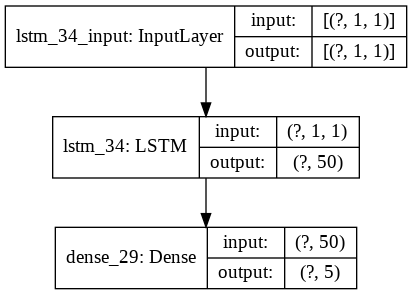

In [117]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps_in, 1))) # 1 timesteps, 1 feature
model.add(Dense(n_steps_out)) # timestep
model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, y_train, epochs=500, validation_split=0.2, verbose=0)
y_train_pred=model.predict(X_train)
y_test_pred=model.predict(X_test)
print('train rmse:', np.sqrt(mean_squared_error(y_train, y_train_pred)))
print('test rmse:', np.sqrt(mean_squared_error(y_test, y_test_pred)))
plot_model(model, show_shapes=True, show_layer_names=True)

One to many with repeat vector

Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_62 (LSTM)               (None, 50)                10400     
_________________________________________________________________
repeat_vector_21 (RepeatVect (None, 5, 50)             0         
_________________________________________________________________
lstm_63 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_50 (Dense)             (None, 5)                 255       
Total params: 30,855
Trainable params: 30,855
Non-trainable params: 0
_________________________________________________________________
None


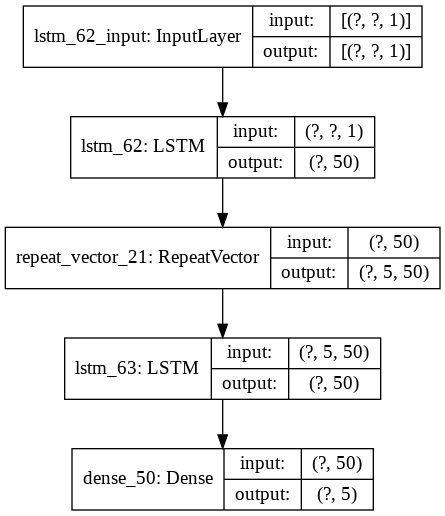

In [153]:
model = Sequential()
model.add(LSTM(50, input_shape=(None,1)))
#model.add(Dense(10))
model.add(RepeatVector(n_steps_out)) #5 timesteps with 50 features
model.add(LSTM(50, #return_sequences=True))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')
print(model.summary())
plot_model(model, show_shapes=True, show_layer_names=True)

In [154]:
history = model.fit(X_train, y_train, epochs=500, validation_split=0.2, verbose=0)
y_train_pred=model.predict(X_train)
y_test_pred=model.predict(X_test)
print('train rmse:', np.sqrt(mean_squared_error(y_train, y_train_pred)))
print('test rmse:', np.sqrt(mean_squared_error(y_test, y_test_pred)))

train rmse: 0.001395657612968389
test rmse: 0.0015379430141158098


Model: "sequential_70"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_80 (LSTM)               (None, 50)                10400     
_________________________________________________________________
repeat_vector_29 (RepeatVect (None, 5, 50)             0         
_________________________________________________________________
lstm_81 (LSTM)               (None, 5, 50)             20200     
_________________________________________________________________
time_distributed_13 (TimeDis (None, 5, 50)             2550      
_________________________________________________________________
lstm_82 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_59 (Dense)             (None, 5)                 255       
Total params: 53,605
Trainable params: 53,605
Non-trainable params: 0
_________________________________________________

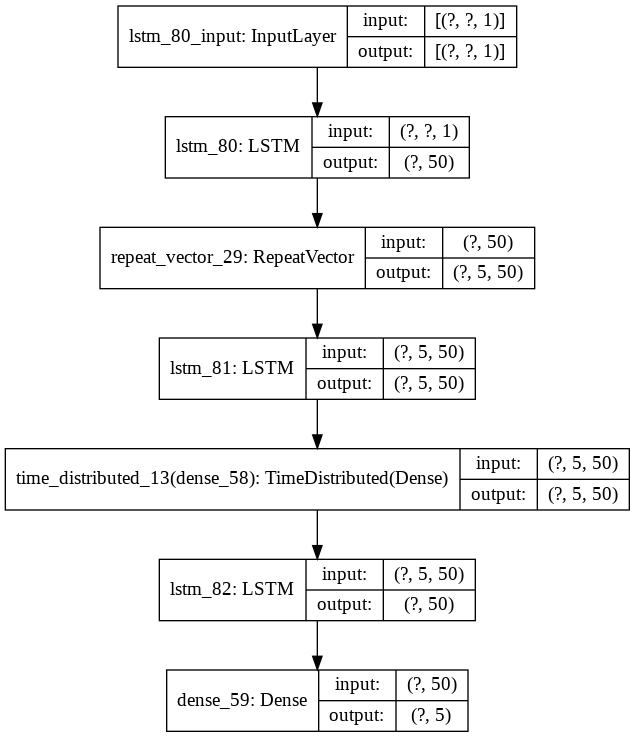

In [166]:
model = Sequential()
model.add(LSTM(50, input_shape=(None,1)))
#model.add(Dense(10))
model.add(RepeatVector(n_steps_out)) #5 timesteps with 50 features
model.add(LSTM(50, return_sequences=True))
model.add(TimeDistributed(Dense(50)))
model.add(LSTM(50))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')
print(model.summary())
plot_model(model, show_shapes=True, show_layer_names=True)

In [167]:
history = model.fit(X_train, y_train, epochs=500, validation_split=0.2, verbose=0)
y_train_pred=model.predict(X_train)
y_test_pred=model.predict(X_test)
print('train rmse:', np.sqrt(mean_squared_error(y_train, y_train_pred)))
print('test rmse:', np.sqrt(mean_squared_error(y_test, y_test_pred)))

train rmse: 0.0013928523360431824
test rmse: 0.00153293796396321


One to many with stateful = True

Model: "sequential_78"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_90 (LSTM)               (5, None, 5)              140       
_________________________________________________________________
dense_61 (Dense)             (5, None, 5)              30        
Total params: 170
Trainable params: 170
Non-trainable params: 0
_________________________________________________________________
None


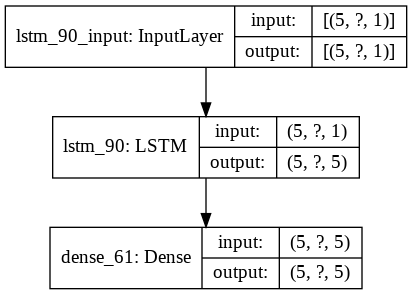

In [179]:
batch_size=5
model = Sequential()
model.add(LSTM(n_steps_out,stateful=True,return_sequences=True, 
               batch_input_shape=(batch_size,None,1)))
#model.add(Dense(10))
#model.add(LSTM(50, #return_sequences=True))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')
print(model.summary())
plot_model(model, show_shapes=True, show_layer_names=True)

In [181]:
X_train.shape

(17, 1, 1)

In [182]:
y_train.shape

(17, 5)

In [180]:
#history = model.fit(X_train, y_train, epochs=500, validation_split=0.2, verbose=0)
for i in range(300):
	model.fit(X_train, y_train, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
	model.reset_states()

y_train_pred=model.predict(X_train,batch_size=batch_size)
y_test_pred=model.predict(X_test,batch_size=batch_size)
print('train rmse:', np.sqrt(mean_squared_error(y_train, y_train_pred)))
print('test rmse:', np.sqrt(mean_squared_error(y_test, y_test_pred)))

InvalidArgumentError: ignored

#### Many to many

In [183]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [184]:
df=DFdict_final['C-Pitch'][['Datef','C-Pitch']].set_index('Datef')
df=df['C-Pitch']
df.head()

Datef
2019-01-11    10.004
2019-01-22    10.001
2019-01-26    10.002
2019-01-31    10.003
2019-02-11    10.003
Name: C-Pitch, dtype: float64

In [185]:
split_number=0.80
n_steps_in  = 7
n_steps_out = 5
n_features=1
split=int(len(df) * split_number)
training_set=df[:split]
test_set=df[split:]
predict_future=len(test_set)
#prepare training set
X_train, y_train = split_sequence(training_set, n_steps_in, n_steps_out)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
print(X_train.shape)
print(y_train.shape)
#prepare test set
inputs=df[len(df)-len(test_set) - n_steps_in:]
X_test, y_test = split_sequence(inputs, n_steps_in, n_steps_out)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
print(X_test.shape)
print(y_test.shape)

(11, 7, 1)
(11, 5)
(2, 7, 1)
(2, 5)


Normal method

train rmse: 0.0013723530851400025
test rmse: 0.0022290454654526745


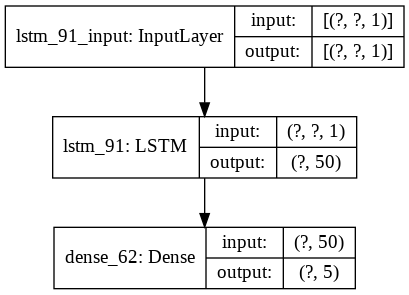

In [186]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(None, 1))) # 7 timesteps, 1 feature
model.add(Dense(n_steps_out)) # one timestep
model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, y_train, epochs=500, validation_split=0.2, verbose=0)
y_train_pred=model.predict(X_train)
y_test_pred=model.predict(X_test)
print('train rmse:', np.sqrt(mean_squared_error(y_train, y_train_pred)))
print('test rmse:', np.sqrt(mean_squared_error(y_test, y_test_pred)))
plot_model(model, show_shapes=True, show_layer_names=True)

Repeat vector and time distribute:

Model: "sequential_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_94 (LSTM)               (None, 50)                10400     
_________________________________________________________________
repeat_vector_31 (RepeatVect (None, 5, 50)             0         
_________________________________________________________________
lstm_95 (LSTM)               (None, 5, 100)            60400     
_________________________________________________________________
time_distributed_15 (TimeDis (None, 5, 1)              101       
Total params: 70,901
Trainable params: 70,901
Non-trainable params: 0
_________________________________________________________________


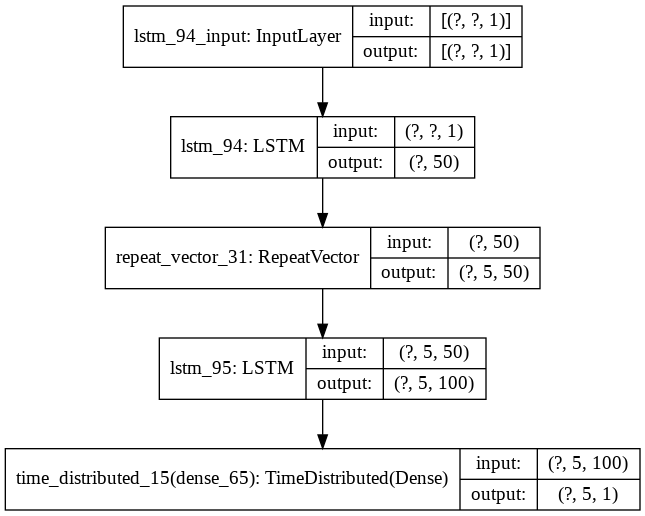

In [209]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(None, 1))) # n timesteps, 1 feature
model.add(RepeatVector(n_steps_out)) # output: n timesteps, 100 features
#model.add(Dense(n_steps_out)) # n timesteps
# decoder layer
model.add(LSTM(100, activation='relu', return_sequences=True)) #output: n timesteps,100 features
model.add(TimeDistributed(Dense(1))) #output: n timesteps, 1 features
model.compile(optimizer='adam', loss='mse')
model.summary()
plot_model(model, show_shapes=True, show_layer_names=True)

In [210]:
history = model.fit(X_train, y_train, epochs=500, validation_split=0.2, verbose=0)
y_train_pred=model.predict(X_train)
y_test_pred=model.predict(X_test)
y_train_pred=y_train_pred.reshape(y_train_pred.shape[0],y_train_pred.shape[1])
y_test_pred=y_test_pred.reshape(y_test_pred.shape[0],y_test_pred.shape[1])
print('train rmse:', np.sqrt(mean_squared_error(y_train, y_train_pred)))
print('test rmse:', np.sqrt(mean_squared_error(y_test, y_test_pred)))

train rmse: 0.0016736935079022562
test rmse: 0.002527285137687262


Solution via Bidirectional LSTM

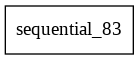

In [212]:
model = Sequential()
model.add(Bidirectional(LSTM(100, activation='relu', input_shape=(None, 1))))
model.add(RepeatVector(n_steps_out)) # 5,100
model.add(Bidirectional(LSTM(100, activation='relu', return_sequences=True)))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')


In [213]:
history = model.fit(X_train, y_train, epochs=500, validation_split=0.2, verbose=0)
y_train_pred=model.predict(X_train)
y_test_pred=model.predict(X_test)
y_train_pred=y_train_pred.reshape(y_train_pred.shape[0],y_train_pred.shape[1])
y_test_pred=y_test_pred.reshape(y_test_pred.shape[0],y_test_pred.shape[1])
print('train rmse:', np.sqrt(mean_squared_error(y_train, y_train_pred)))
print('test rmse:', np.sqrt(mean_squared_error(y_test, y_test_pred)))

train rmse: 0.0030986083338294173
test rmse: 0.0031959487145100753


Model: "sequential_83"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 200)               81600     
_________________________________________________________________
repeat_vector_33 (RepeatVect (None, 5, 200)            0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 5, 200)            240800    
_________________________________________________________________
time_distributed_17 (TimeDis (None, 5, 1)              201       
Total params: 322,601
Trainable params: 322,601
Non-trainable params: 0
_________________________________________________________________
None


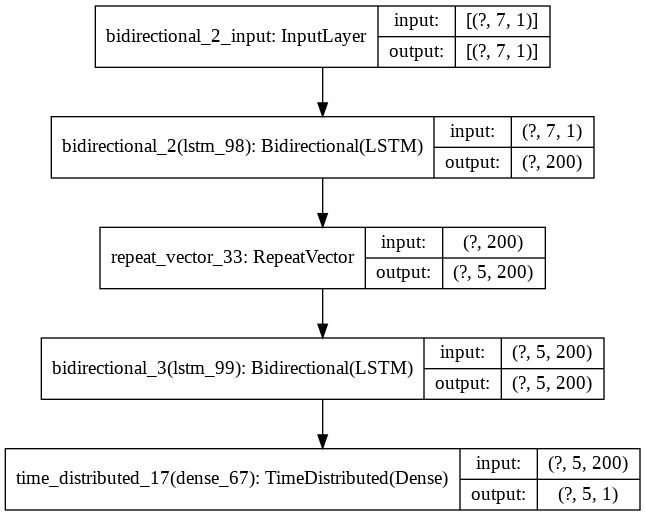

In [215]:
print(model.summary())
plot_model(model, show_shapes=True, show_layer_names=True)

### Example outside

In [88]:
data = array([[0.1,0.3], [0.2,0.4], [0.3,0.5]]).reshape((1,3,2))
data

array([[[0.1, 0.3],
        [0.2, 0.4],
        [0.3, 0.5]]])

[[0.14516293 0.05231286 0.03136804 0.07186063 0.00358471 0.
  0.         0.01613052 0.         0.        ]]


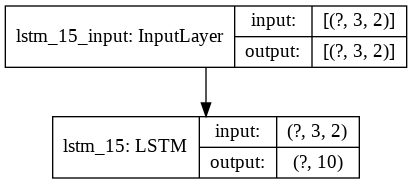

In [89]:
from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from numpy import array
# define model
model = Sequential()
model.add(LSTM(10, activation='relu', input_shape=(3, 2)))
# define input data
# make and show prediction
print(model.predict(data))
plot_model(model, show_shapes=True, show_layer_names=True)

[[[0.02448946 0.         0.         0.         0.01724279 0.
   0.00596744 0.         0.02368724 0.        ]
  [0.04824209 0.         0.         0.         0.03156136 0.
   0.00954113 0.         0.05294318 0.        ]
  [0.07176429 0.         0.         0.         0.04378173 0.
   0.01075361 0.         0.08532153 0.        ]]]


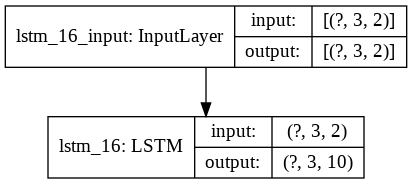

In [90]:
# define model
model = Sequential()
model.add(LSTM(10, activation='relu',return_sequences=True, input_shape=(3, 2)))
# define input data
#data = array([0.1, 0.2, 0.3]).reshape((1,3,1))
# make and show prediction
print(model.predict(data))
plot_model(model, show_shapes=True, show_layer_names=True)

[[[-0.00376241 -0.00408842]
  [-0.00981246 -0.01051156]
  [-0.01727481 -0.01822502]
  [-0.02982115 -0.03070307]]]
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 4, 10)             480       
_________________________________________________________________
dense_12 (Dense)             (None, 4, 5)              55        
_________________________________________________________________
dense_13 (Dense)             (None, 4, 2)              12        
Total params: 547
Trainable params: 547
Non-trainable params: 0
_________________________________________________________________


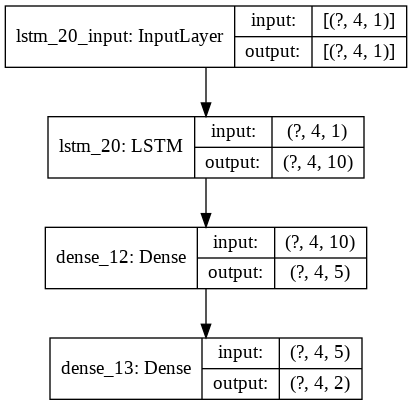

In [94]:
# define model
model = Sequential()
model.add(LSTM(10, activation='relu',return_sequences=True, 
               input_shape=(4, 1))) # du nhap input shape la gi thi cung bang input shap sample, co the de None
model.add(Dense(5))
model.add(Dense(2))
# define input data
data = array([0.1, 0.2, 0.3,0.5]).reshape((1,4,1))
# make and show prediction
print(model.predict(data))
model.summary()
plot_model(model, show_shapes=True, show_layer_names=True)

[[ 0.0837535  -0.02614799]]
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 10)                480       
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 12        
Total params: 547
Trainable params: 547
Non-trainable params: 0
_________________________________________________________________


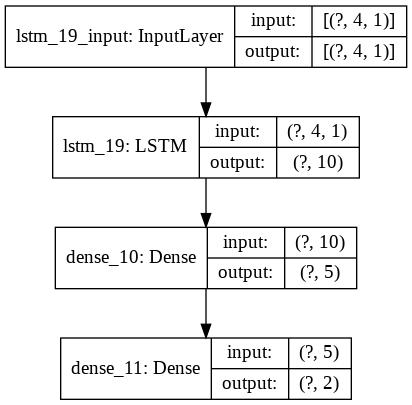

In [93]:
# define model
model = Sequential()
model.add(LSTM(10, activation='relu',#return_sequences=True, 
               input_shape=(4, 1))) # du nhap input shape la gi thi cung bang input shap sample, co the de None
model.add(Dense(5))
model.add(Dense(2))
# define input data
data = array([0.1, 0.2, 0.3,0.5]).reshape((1,4,1))
# make and show prediction
print(model.predict(data))
model.summary()
plot_model(model, show_shapes=True, show_layer_names=True)

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_26 (LSTM)               (None, 1)                 12        
Total params: 12
Trainable params: 12
Non-trainable params: 0
_________________________________________________________________


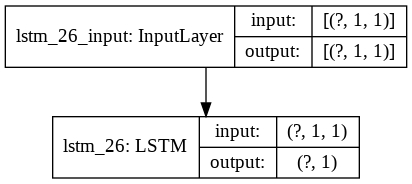

In [100]:
model = Sequential()
model.add(LSTM(1, activation='relu', input_shape=(1, 1))) # 3 timesteps, 1 feature
#model.add(Dense(1)) # one timestep
model.compile(optimizer='adam', loss='mse')
model.summary()
plot_model(model, show_shapes=True, show_layer_names=True)

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 32)                1056      
_________________________________________________________________
repeat_vector (RepeatVector) (None, 3, 32)             0         
Total params: 1,056
Trainable params: 1,056
Non-trainable params: 0
_________________________________________________________________


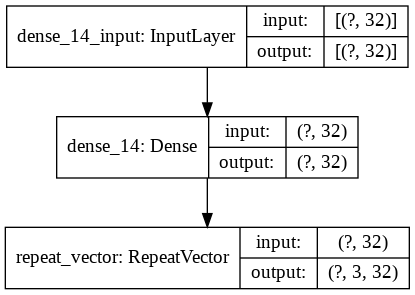

In [101]:
model = Sequential()
model.add(Dense(32, input_dim=32))
# now: model.output_shape == (None, 32)
# note: `None` is the batch dimension
model.add(RepeatVector(3))
# now: model.output_shape == (None, 3, 32)
model.summary()
plot_model(model, show_shapes=True, show_layer_names=True)

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_21 (Dense)             (None, 3)                 99        
Total params: 1,155
Trainable params: 1,155
Non-trainable params: 0
_________________________________________________________________


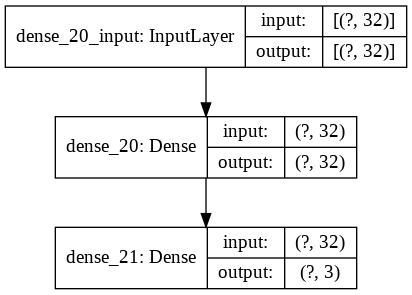

In [104]:
model = Sequential()
model.add(Dense(32, input_dim=32))
# now: model.output_shape == (None, 32)
# note: `None` is the batch dimension
model.add(Dense(3))
# now: model.output_shape == (None, 3, 32)
model.summary()
plot_model(model, show_shapes=True, show_layer_names=True)

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_29 (LSTM)               (None, 3, 128)            67072     
_________________________________________________________________
lstm_30 (LSTM)               (None, 64)                49408     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 3, 64)             0         
_________________________________________________________________
lstm_31 (LSTM)               (None, 3, 64)             33024     
_________________________________________________________________
lstm_32 (LSTM)               (None, 3, 128)            98816     
_________________________________________________________________
time_distributed_6 (TimeDist (None, 3, 2)              258       
Total params: 248,578
Trainable params: 248,578
Non-trainable params: 0
_______________________________________________

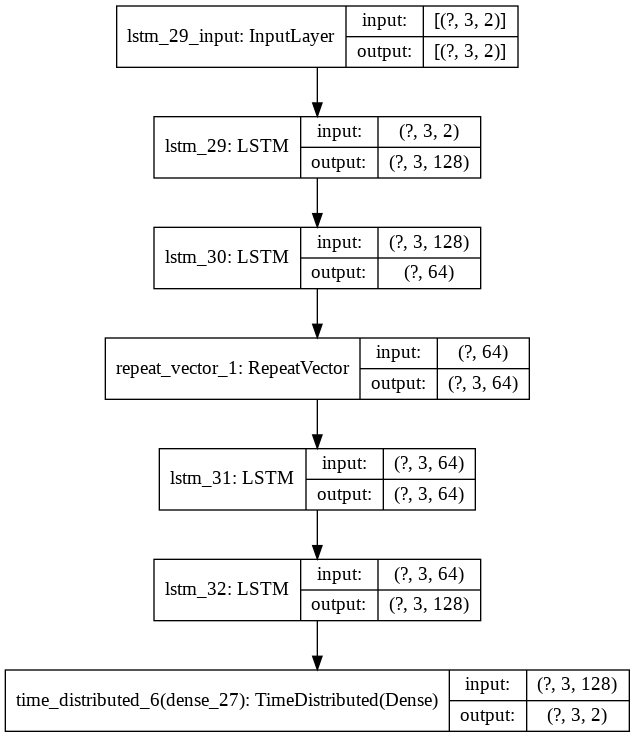

In [112]:
# define model
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(3,2), return_sequences=True))
model.add(LSTM(64, activation='relu', return_sequences=False))
model.add(RepeatVector(3))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(2)))
model.compile(optimizer='adam', loss='mse')
model.summary()
plot_model(model, show_shapes=True, show_layer_names=True)

## SARIMA

In [ ]:
import itertools    
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.filterwarnings("ignore")

def arima_grid_search(dataframe, s):
    df=dataframe
    p = d = q = range(2)
    param_combinations = list(itertools.product(p, d, q))

    lowest_aic, pdq, pdqs = None, None, None

    total_iterations = 0
    for order in param_combinations:    
        for (p, q, d) in param_combinations:
            seasonal_order = (p, q, d, s)
            total_iterations += 1
            try:
                model = SARIMAX(df, order=order, 
                    seasonal_order=seasonal_order, 
                    enforce_stationarity=False,
                    enforce_invertibility=False,
                    disp=False
                )
                model_result = model.fit(maxiter=200, disp=False)

                if not lowest_aic or model_result.aic < lowest_aic:
                    lowest_aic = model_result.aic
                    pdq, pdqs = order, seasonal_order

            except Exception as ex:
                continue

    return lowest_aic, pdq, pdqs 

In [ ]:
for name in DFdict_final.keys(): #also group
  print(name)
  df_temp_2=DFdict_final[name].copy() # gia tri mean thong thuong
  df_predict=df_temp_2.set_index(df_temp_2.columns[0]).copy()
  df_predict=df_predict.resample('1W').ffill() # gia tri mean da resample
  df_original=df_predict.reset_index()#
  #df_lstm=df_lstm[[df_lstm.columns[0],df_lstm.columns[1]]]
  #df_fb.columns=['ds','y']
  break
df=df_original[[df_original.columns[0],df_original.columns[1]]].\
    set_index(df_original.columns[0])
df.head()

In [ ]:
df_sarima=df[df.columns[0]].copy()
df_sarima

In [ ]:
lowest_aic, order, seasonal_order = arima_grid_search(df_sarima, 12)
print('ARIMA{}x{}'.format(order, seasonal_order))
print('Lowest AIC: %.3f'%lowest_aic)

In [ ]:
model = SARIMAX(
    df_sarima,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False,
    disp=False
)

model_results = model.fit(maxiter=200, disp=False)

In [ ]:
print(model_results.summary())

In [ ]:
model_results.plot_diagnostics(figsize=(12, 8));

In [ ]:
model_results.resid.describe()

In [ ]:
n = len(df_sarima.index)
n

In [ ]:
num_predict=5

In [ ]:
prediction = model_results.get_prediction(
    start=n-num_predict, 
    end=n+num_predict
)
prediction_ci = prediction.conf_int()

In [ ]:
prediction_ci.head()

In [ ]:
df_sarima.head()

In [ ]:
plt.figure(figsize=(12, 6))

ax = df_sarima.plot(label='actual')

prediction_ci.plot(
    ax=ax, style=['--', '--'],
    label='predicted/forecasted')

prediction.predicted_mean.plot(
    ax=ax, style=['--'],
    label='predicted')

ci_index = prediction_ci.index
lower_ci = prediction_ci.iloc[:, 0]
upper_ci = prediction_ci.iloc[:, 1]

ax.fill_between(ci_index, lower_ci, upper_ci,
    color='r', alpha=.1)

ax.set_xlabel('Time (years)')
ax.set_ylabel('Prices')

plt.legend()
plt.show()